# Generating 10,000 FSPS spectra with parameters randomly sampled

In [72]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import fsps
from astroML.plotting import setup_text_plots
import h5py

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=24)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('font', size=24, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=13)
mpl.rc('axes', labelweight='black')

#### for tau, dust, and sigma, can simply use uniform distributions; but for metallicity, choose randint between 0 and 22

In [73]:
# get 10,000 samples in the 4 parameters (tau, Z, dust2, sigma_smooth)

A = 12.5 # time since the galaxy we're observing started forming stars
sf_begin = 13.7 - A # Gyr after big bang
size=10000

#taus = np.random.uniform(low=0.1, high=100, size=size) # this resulted in WAY too few old galaxies
logtaus = np.random.uniform(low=-0.5, high=1.5, size=size)
taus = 10**logtaus
ages = A - taus * ( (1. - (A/taus + 1.) * np.exp(-A/taus)) / \
                             (1. - np.exp(-A/taus)) ) # mean ages given taus

dusts = np.random.uniform(low=0.0, high=1.5, size=size)

sigmas = np.random.uniform(low=0.0, high=300.0, size=size)

In [74]:
# do metallicity separately b/c need to choose integer for each model -- logz_values copied from FSPS manual
logz_values = np.array([-1.98, -1.80, -1.68, -1.58, -1.50, -1.38, -1.28, -1.20, -1.07, -0.98, -0.89, -0.79, \
                        -0.69, -0.59, -0.49, -0.39, -0.30, -0.20, -0.10, 0.0, 0.10, 0.20])

znums = np.random.randint(low=1, high=23, size=size) #want values from 1-22; high is exclusive
zinds = znums - 1 #b/c the znum starts at 1, not 0... ugh
zs = logz_values[zinds]

#### now build the model spectra

In [75]:
spectra = np.zeros((size, 4220)) #know there are 4220 steps in desired wavelength range
ii = 0

for tau, znum, dust, sigma in zip(taus, znums, dusts, sigmas):
    sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=1,  zmet=znum, sigma_smooth=sigma, \
                    dust_type=2, dust2=dust, sf_start=sf_begin, tau=tau, add_neb_emission=False)
    wave, spec = sp.get_spectrum(tage=12.5, peraa=True)
    wh = (wave < 7400.) * (wave > 3600.)
    spectra[ii, :] = spec[wh]
    ii += 1
    if ii%500 == 0:
        percent = ii/100
        print "%d percent complete" % percent

5 percent complete
10 percent complete
15 percent complete
20 percent complete
25 percent complete
30 percent complete
35 percent complete
40 percent complete
45 percent complete
50 percent complete
55 percent complete
60 percent complete
65 percent complete
70 percent complete
75 percent complete
80 percent complete
85 percent complete
90 percent complete
95 percent complete
100 percent complete


#### normalize the spectra

In [76]:
norms = spectra.shape[1] / np.sum(spectra, axis=1)
spectra_norm = spectra * norms[:,np.newaxis]

In [84]:
print zip(taus, znums, dusts, sigmas)[100]
print zip(taus, znums, dusts, sigmas)[1009]
print zip(taus, znums, dusts, sigmas)[6095]
print zip(taus, znums, dusts, sigmas)[9998]

(2.0014471980891635, 6, 0.58812338050636281, 52.190485481497021)
(1.0928188153427933, 11, 1.0306500014816131, 61.69911243110738)
(1.726851061643665, 22, 1.1188270385737094, 209.87086209423359)
(6.498097912310806, 2, 1.3507910476977005, 136.20595982045361)


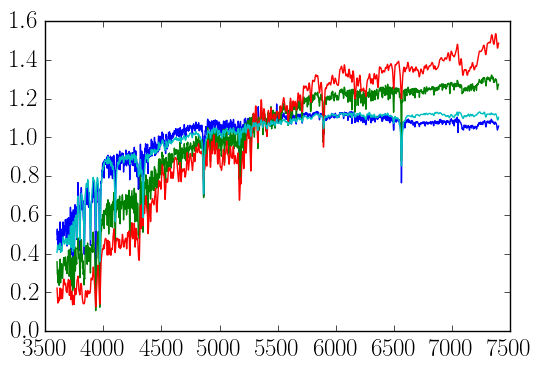

In [77]:
# quick sanity check
plt.figure()
plt.plot(wave[wh], spectra_norm[100])
plt.plot(wave[wh], spectra_norm[1009])
plt.plot(wave[wh], spectra_norm[6095])
plt.plot(wave[wh], spectra_norm[9998])

#### save spectra and parameters to HDF5 file

In [78]:
f = h5py.File('../data/1e4_randsamp_age_model_spectra.hdf5','w')
f.create_dataset('spectra', data=spectra_norm)
f.create_dataset('wave', data=wave[wh])
f.create_dataset('taus', data=taus)
f.create_dataset('ages', data=ages)
f.create_dataset('znums', data=znums)
f.create_dataset('zs', data=zs)
f.create_dataset('dusts', data=dusts)
f.create_dataset('sigmas', data=sigmas)

<HDF5 dataset "sigmas": shape (10000,), type "<f8">

In [79]:
f.keys()

[u'ages', u'dusts', u'sigmas', u'spectra', u'taus', u'wave', u'znums', u'zs']

In [80]:
f['spectra'].shape

(10000, 4220)

In [81]:
f.close()

## Checking the distributions in tau and age

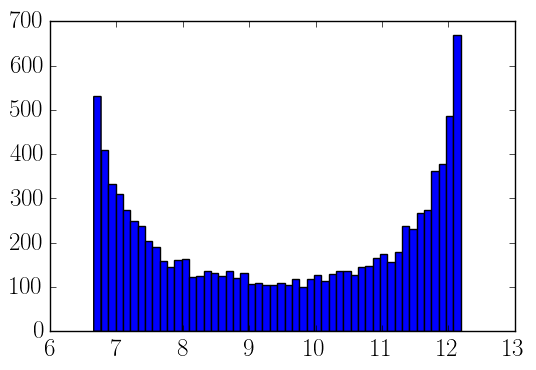

In [85]:
plt.figure()
n, bins, patches = plt.hist(ages, bins=50)

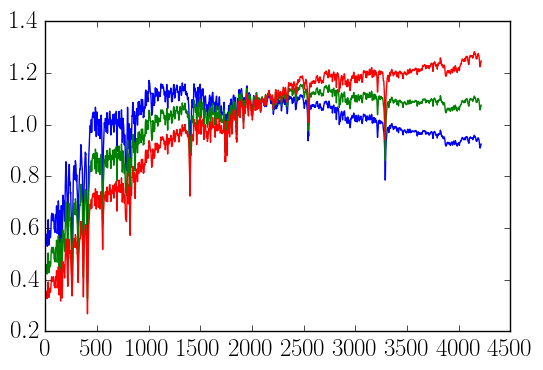

In [91]:
lowdust = np.mean(spectra_norm[dusts < 0.5], axis=0)
middust = np.mean(spectra_norm[(dusts > 0.5) * (dusts < 1.0)], axis=0)
highdust = np.mean(spectra_norm[dusts > 1.0], axis=0)

plt.figure()
plt.plot(lowdust)
plt.plot(middust)
plt.plot(highdust)

42.8231888371 6.55362942555
13.9109016526 7.17365759599
71.5846953487 6.43180172421
54.6305963902 6.48813552911
80.6211625989 6.41144172367


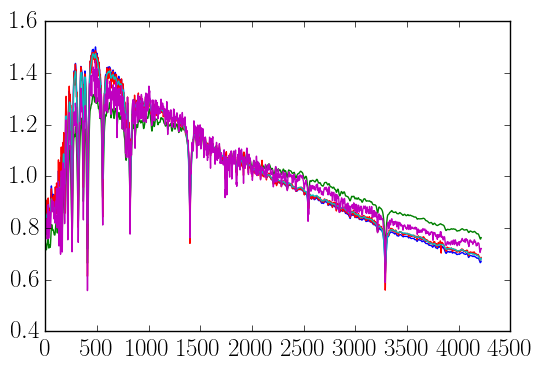

In [65]:
plt.figure()
for ii in range(5):
    print taus[(taus > 10) * (dusts < 0.2)][ii], ages[(taus > 10) * (dusts < 0.2)][ii]
    plt.plot(spectra_norm[(taus > 10) * (dusts < 0.2)][ii, :])
    

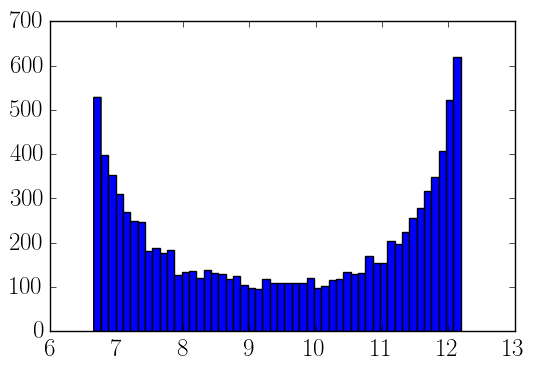

In [71]:
test = np.random.uniform(low=-0.5, high=1.5, size=size)
test2 = 10**test
test3 = A - test2 * ( (1. - (A/test2 + 1.) * np.exp(-A/test2)) / \
                             (1. - np.exp(-A/test2)) ) 
n, bins, patches = plt.hist(test3, bins=50)